In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gwdet
from pdet import VT_pop_uniform_q
from comp_pdet import pdet, snr
from tqdm.auto import tqdm
from joblib import Parallel, delayed

/data/fdesanti/fleto/master_thesis/box/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
pdet(1, 1, 0.1, n_samples=1e4)

0.9996

Combinations of masses and redshifts for which the detection probability is virtually 1 (0.999#) or 0 (0.000#) for a CE (US A location) + ET (Sardinia) network and SNR threshold $8 \sqrt{2}$:

* $p_\text{det} \simeq 1$
    * Anything with $z \leq 0.1$ (and $m_\text{min} \geq 1$)
    * Anything with $z \leq 1$ and $m_\text{min} \geq 30$
    * Anything with $z \leq 2$ and $m_\text{min} \geq 75$
* $p_\text{det} \simeq 0$
    * Anything with $z \geq 6$ and $m_\text{max} \leq 10$

In [3]:
z_min_compute = 0.1
z_max_m_min = ((0.1, 1), (1, 30), (2, 75))
z_min_m_max = ((6, 10),)

In [4]:
m1grid = np.linspace(1, 100, 200)
m2grid = np.linspace(1, 100, 200)
zgrid = np.concatenate((np.geomspace(1e-4, 1, 100, endpoint=False), np.linspace(1, 10, 100)))

grids = (m1grid, m2grid, zgrid)
pdet_for_interpolant = np.zeros([len(grid) for grid in grids])

In [5]:
m1grid = np.concatenate((np.linspace(1, 20, 20, endpoint=False), np.linspace(20, 50, 20, endpoint=False), np.linspace(50, 100, 20)))
m2grid = np.concatenate((np.linspace(1, 20, 20, endpoint=False), np.linspace(20, 50, 20, endpoint=False), np.linspace(50, 100, 20)))
zgrid = np.concatenate((np.geomspace(1e-4, 1e-1, 100, endpoint=False), np.geomspace(1e-1, 1, 50, endpoint=False), np.geomspace(1, 10, 50)))

grids = (m1grid, m2grid, zgrid)
pdet_for_interpolant = np.zeros([len(grid) for grid in grids])

In [6]:
meshcoord = []
meshgrid = []

n_iter = 0
for i, m1 in enumerate(m1grid):
    for j, m2 in zip(range(i, len(m2grid)), m2grid[i:]):
        for k, z in enumerate(zgrid):
            n_iter += 1

with tqdm(total=n_iter, desc="Populating pdet_for_interpolant and meshgrid") as pbar:
    for i, m1 in enumerate(m1grid):
        for j, m2 in zip(range(i, len(m2grid)), m2grid[i:]):
            for k, z in enumerate(zgrid):
                already_known=False
                m12_min = m1 if m1 <= m2 else m2
                for z_max, m_min in z_max_m_min:
                    if z <= z_max and m12_min >= m_min:
                        pdet_for_interpolant[i, j, k] = 1
                        pdet_for_interpolant[j, i, k] = 1
                        already_known=True
                if not already_known:
                    m12_max = m1 if m1 >= m2 else m2
                    for z_min, m_max in z_min_m_max:
                        if z >= z_min and m12_max <= m_max:
                            already_known=True
                if not already_known:
                    meshcoord.append((i, j, k))
                    meshgrid.append((m1 ,m2, z))
                pbar.update(1)

meshcoord = np.array(meshcoord)
meshgrid = np.array(meshgrid)

# Shuffle the arrays to better ditribute load across processors
p = np.random.permutation(len(meshcoord))

meshcoord = meshcoord[p]
meshgrid = meshgrid[p]

print(np.prod(pdet_for_interpolant.shape), meshcoord.shape)

Populating pdet_for_interpolant and meshgrid:   0%|          | 0/366000 [00:00<?, ?it/s]

720000 (151745, 3)


In [7]:
file = np.load("data/pdet_nsamples_1e2_zmc_7e-2_(attempt_1).npz")
m1grid, m2grid, zgrid, pdet_for_interpolant = [file[key] for key in file.files]
grids = (m1grid, m2grid, zgrid)

In [8]:
pdet_interpolant = RegularGridInterpolator(grids, pdet_for_interpolant)

In [9]:
pdet_interpolant(np.array([[10, 10, 1],
                           [24, 37, 5]]))

array([0.97852874, 0.50221642])

In [10]:
seed = 42
np.random.seed(seed)
m1test = np.random.uniform(1, 100, 1000)
m2test = np.random.uniform(1, 100, 1000)
ztest = np.concatenate((10 ** np.random.uniform(-2, 0, 500), np.random.uniform(1, 10, 500)))

In [11]:
interpolated_pdet = pdet_interpolant(np.vstack((m1test, m2test, ztest)).T)

In [12]:
file = np.load("data/pdet_test_nsamples_1e2_npoints_1e3_seed_42.npz")
m1test, m2test, ztest, pdet_test = [file[key] for key in file.files]

/tmp/ipykernel_3430000/3498768802.py:1: RuntimeWarning: divide by zero encountered in divide
  rel_err = (interpolated_pdet - pdet_test) / pdet_test
/tmp/ipykernel_3430000/3498768802.py:1: RuntimeWarning: invalid value encountered in divide
  rel_err = (interpolated_pdet - pdet_test) / pdet_test


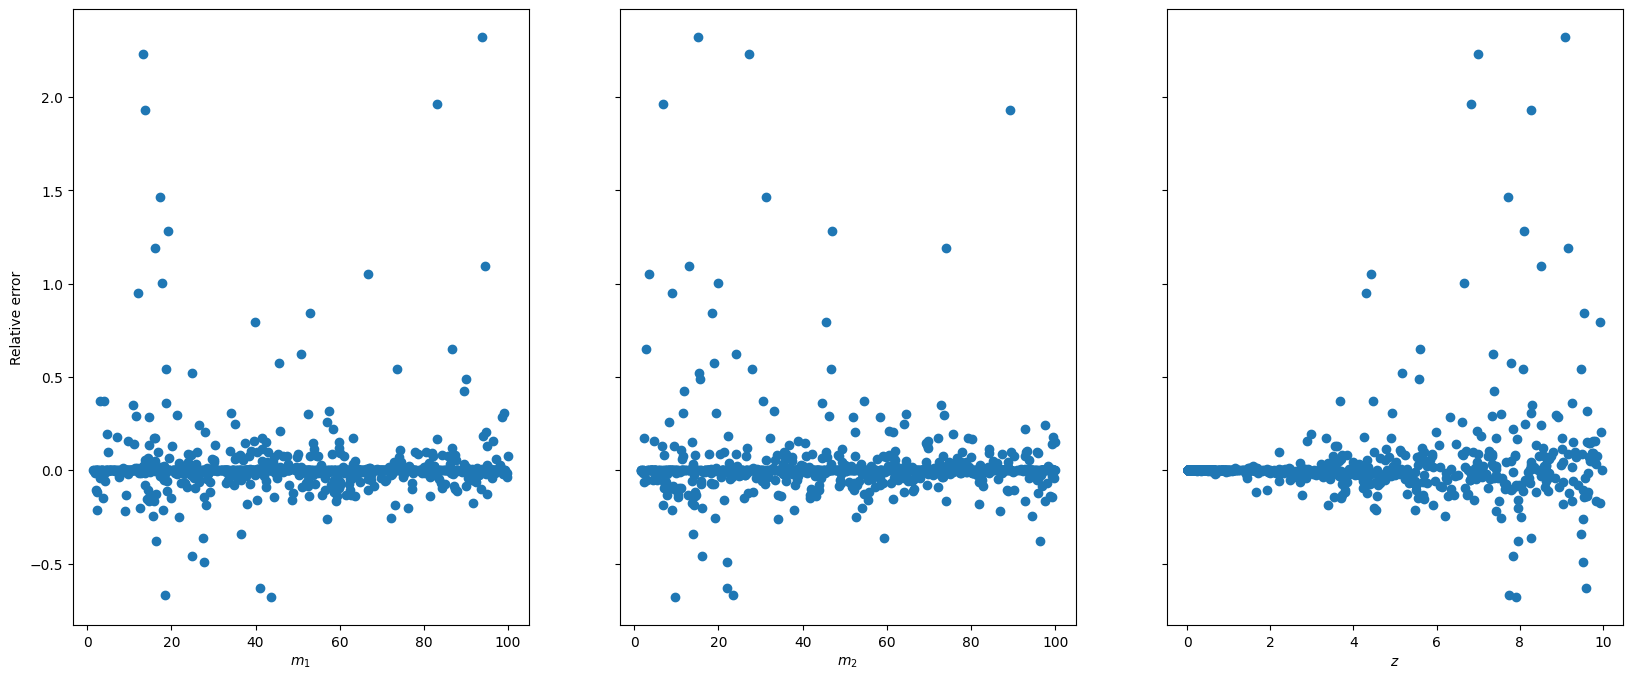

[np.int64(133), np.int64(88), np.int64(39), np.int64(30)]


In [29]:
rel_err = (interpolated_pdet - pdet_test) / pdet_test

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), sharey=True)

for ax, grid, xlb in zip(axes, (m1test, m2test, ztest), (r'$m_1$', r'$m_2$', r'$z$')):
    ax.scatter(grid, rel_err)
    ax.set_xlabel(xlb)
axes[0].set_ylabel('Relative error')

plt.show()

print([np.sum(rel_err > lv) for lv in (0.05, 0.1, 0.5, 1)])

In [14]:
m1_min, m1_max, m1_len = 1, 100, 100
q = 0.8 # m2 / m1, with m2 <= m1. Below q = 0.3 plots become a bit messy
z_min, z_max, z_len = 1e-4, 2.2, 50
m1 = np.linspace(1, 100, m1_len)
m2 = m1 * q
z = np.linspace(1e-4, 2.2, z_len)

In [15]:
p = gwdet.detectability()

In [16]:
# with open('data/18213_ET10kmcolumns.txt', 'r') as file:
#     new_lines = []
#     while True:
#         line = file.readline()
#         if line == '':
#             break
#         else:
#             line = line.split(' ')
#             new_lines.append(line[0] + ' ' + line[3])

# with open('data/ET_ASD_file.txt', 'x') as file:
#     file.writelines(new_lines)

In [17]:
with open('data/ET_ASD_file.txt', 'r') as file:
    lines = file.readlines()

f = np.zeros(len(lines))
for i, line in enumerate(lines):
    f[i] = float(line.split(' ')[0])

delta_f = f[1:] - f[:-1]

In [18]:
np.min(delta_f)

np.float64(0.0030758579429499555)

In [19]:
# p = gwdet.detectability(directory='data/', psd_from_path=True, psd_path='data/ET_ASD_file.txt', is_asd_file=True,
#                         flow=1., deltaf=1 / 40, snrthreshold=8., massmin=1, massmax=200, zmin=1e-4, zmax=2.2)

In [20]:
p_det = np.zeros((z_len, m1_len))

for i, _z in enumerate(z):
    p_det[i] = p(m1, m2, np.zeros(m1_len) + _z)

In [21]:
np.sum(p_det < 0)

np.int64(0)

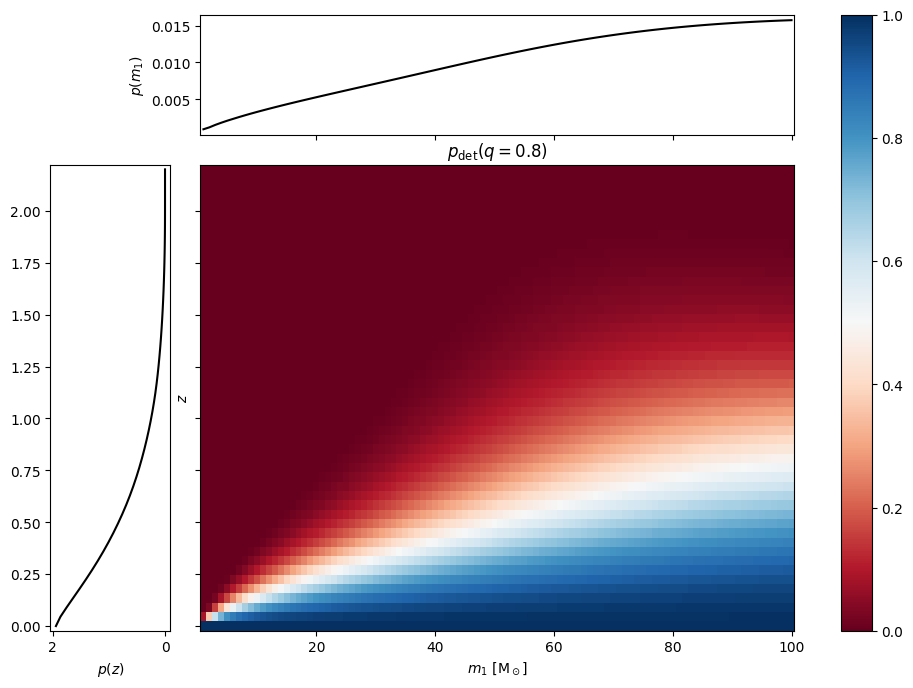

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
divider = make_axes_locatable(ax)

ax_m = divider.append_axes('top', 1.2, pad=0.3, sharex=ax)
ax_z = divider.append_axes('left', 1.2, pad=0.3, sharey=ax)

ax.tick_params(labelleft=False)
ax_m.tick_params(labelbottom=False)

ax.set_title(r'$p_\text{{det}} (q = {0})$'.format(q))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

cmap = plt.colormaps['RdBu']
im = ax.pcolormesh(m1, z, p_det, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=1))

fig.colorbar(im, ax=ax)

ax_m.set_ylabel(r'$p(m_1)$')

ax_m.plot(m1, np.sum(p_det, axis=0) / np.trapezoid(np.sum(p_det, axis=0), m1), color='black')

ax_z.set_xlabel(r'$p(z)$')

ax_z.xaxis.set_inverted(True)

ax_z.plot(np.sum(p_det, axis=1) / np.trapezoid(np.sum(p_det, axis=1), z), z, color='black')

plt.show()

In [23]:
if __name__ == '__main__':
    VT = VT_pop_uniform_q(1, z, m1, q)

Computing VT for each (m, z) pair for a uniformly distributed population of sources with fixed q = 0.8:   0%| …

In [24]:
np.sum(VT < 0)

np.int64(0)

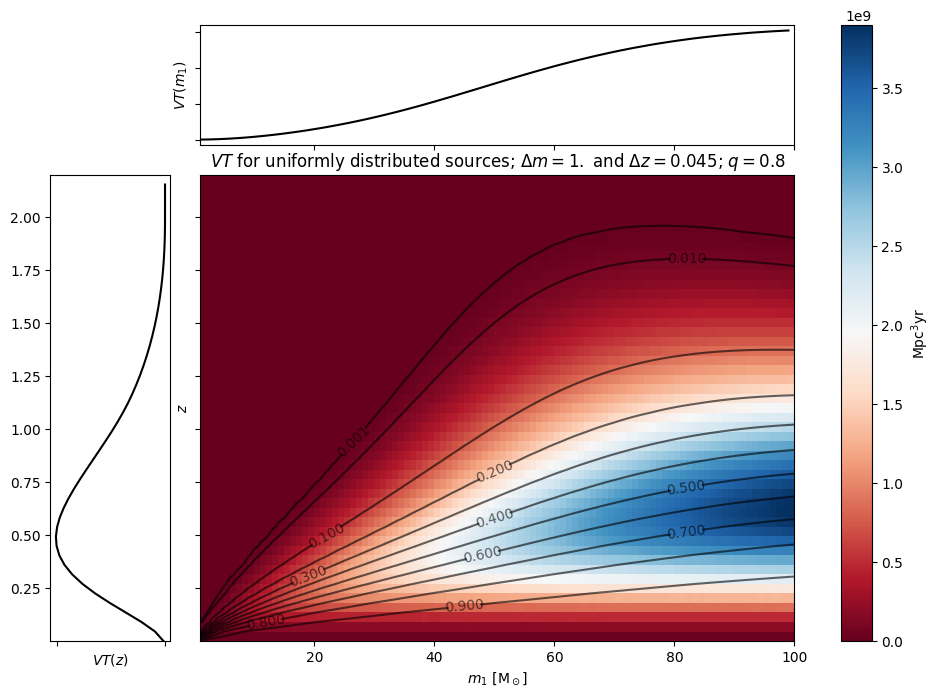

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))

divider = make_axes_locatable(ax)

ax_m = divider.append_axes('top', 1.2, pad=0.3, sharex=ax)
ax_z = divider.append_axes('left', 1.2, pad=0.3, sharey=ax)

ax.tick_params(labelleft=False)
ax_m.tick_params(labelbottom=False, labelleft=False)
ax_z.tick_params(labelbottom=False)

ax.set_title(r'$VT$ for uniformly distributed sources; $\Delta m = {0}$ and $\Delta z = {1}$; $q = {2}$'.format(np.format_float_positional((m1_max - m1_min) / (m1_len - 1), 3),
                                                                                                                np.format_float_positional((z_max - z_min) / (z_len - 1), 3),
                                                                                                                np.format_float_positional(q, 3)))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

# VT heatmap
cmap = plt.colormaps['RdBu']
im = ax.pcolormesh(m1, z, VT, cmap=cmap, norm=mpl.colors.Normalize(vmin=np.min(VT), vmax=np.max(VT)))

# pdet contour levels
levels = [1e-3, 1e-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
cf = ax.contour(m1, z, p_det, levels=levels, colors='black', alpha=0.6)
ax.clabel(cf)

cbar = fig.colorbar(im, ax=ax, label=r'$\text{Mpc}^3 \text{yr}$')

ax_m.set_ylabel(r'$VT(m_1)$')

ax_m.plot(m1[:-1], np.sum(VT, axis=0), color='black')

ax_z.set_xlabel(r'$VT(z)$')

ax_z.xaxis.set_inverted(True)

ax_z.plot(np.sum(VT, axis=1), z[:-1], color='black')

plt.show()

/tmp/ipykernel_3430000/3420535131.py:8: RuntimeWarning: divide by zero encountered in divide
  VT_ratio_map = target_VT / VT


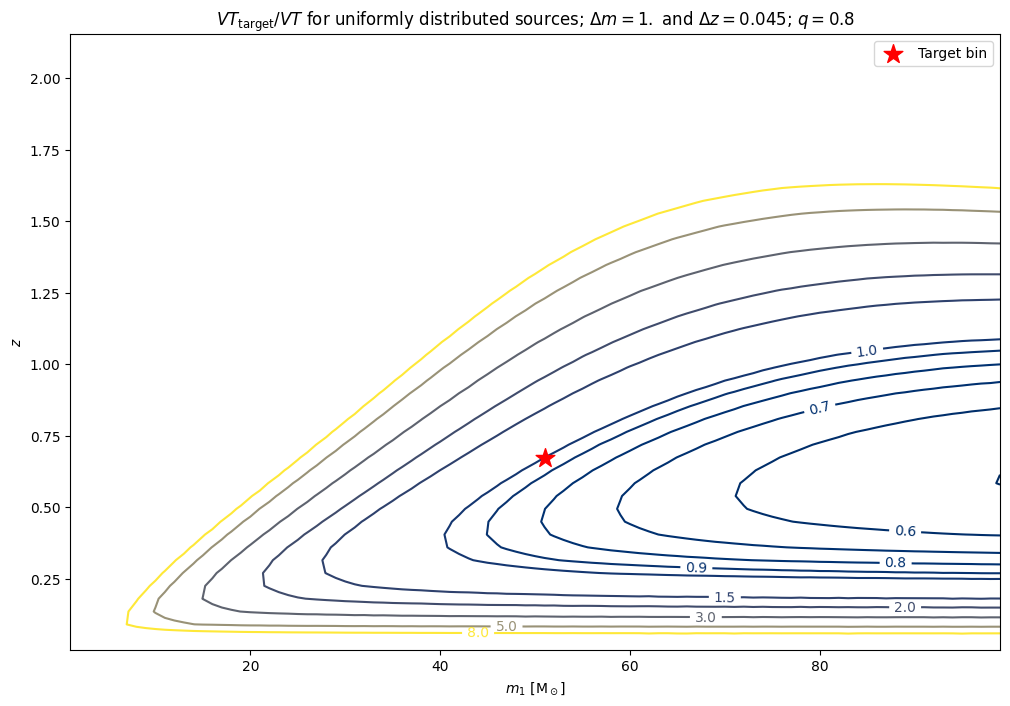

In [26]:
# # Define the target bin using its relative position in the grid
# rx, ry = 0.5, 0.3
# target_bin = (int(rx * (VT.T.shape[0] - 1)), int(ry * (VT.T.shape[1] - 1)))

target_bin = (50, 15)

target_VT = VT.T[*target_bin]
VT_ratio_map = target_VT / VT

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_title(r'${{VT}}_\text{{target}} / VT$ for uniformly distributed sources; $\Delta m = {0}$ and $\Delta z = {1}$; $q = {2}$'.format(np.format_float_positional((m1_max - m1_min) / (m1_len - 1), 3),
                                                                                                                                         np.format_float_positional((z_max - z_min) / (z_len - 1), 3),
                                                                                                                                         np.format_float_positional(q, 3)))
ax.set_xlabel(r'$m_1\ [\text{M}_\odot$]')
ax.set_ylabel(r'$z$')

cmap = plt.colormaps['cividis']
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 3, 5, 8]

cf = ax.contour(m1[:-1], z[:-1], VT_ratio_map, levels=levels, cmap=cmap)
ax.clabel(cf)

ax.scatter(m1[target_bin[0]], z[target_bin[1]], color='red', marker='*', s=200, zorder=100, label='Target bin')

ax.legend()

plt.show()